In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def get_data(n=100, d=2, seed=0):
	np.random.seed(seed)
	X = np.random.randn(n, d)
	Y = np.random.randint(0, d, n)
	return X, Y

In [3]:
class KNN():
    class Node():
        def __init__(self, median=None, split_dim=None, left=None, right=None, points=None):
            self.median = median
            self.split_dim = split_dim
            self.left = left
            self.right = right
            self.points = points
            self.is_leaf = points is not None
            
        def __repr__(self):
            return f"Node(median={self.median}, split_dim={self.split_dim}, points={self.points}, is_leaf={self.is_leaf})"

    class KDTree():
        def __init__(self, X, Y, max_depth=3):
            self.X = X
            self.Y = Y
            self.root = None
            self.max_depth = max_depth
            self.split_dims = np.random.permutation(X.shape[1])
            self.dims = X.shape[1]

        def build_tree(self, X, Y, max_depth):
            if len(X) == 0:
                return None
            if max_depth == 0 or len(X) == 1:
                return KNN.Node(points = (X, Y))
            split_dim = self.split_dims[max_depth % self.dims]
            median = np.median(X[:, split_dim])
            left = X[:, split_dim] < median
            right = X[:, split_dim] >= median

            return KNN.Node(median, split_dim, self.build_tree(X[left], Y[left], max_depth - 1), self.build_tree(X[right], Y[right], max_depth - 1))
        
        def query(self, x, k):
            x_vals, best = self.query_recursive(self.root, x, k)
            return x_vals, best
        
        def query_recursive(self, node, x, k):
            if node.is_leaf:
                dist = np.linalg.norm(node.points[0] - x, axis=1)
                idx = np.argsort(dist, axis=0)
                if len(idx) > k:
                    idx = idx[:k]
                best = sorted([(dist[i], node.points[1][i]) for i in idx])
                x_vals = node.points[0][idx]
                
                return x_vals, best
            if x[node.split_dim] < node.median:
                x_vals, best = self.query_recursive(node.left, x, k)
            else:
                x_vals, best = self.query_recursive(node.right, x, k)
                
            return x_vals, best
        
        def visualize(self, nearest_points, query_pt):
            fig,ax = plt.subplots(figsize=(5, 5))
            ax.scatter(self.X[:, 0], self.X[:, 1], s=100)
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
            ax.set_xticks(np.arange(min(self.X[:, 0]), max(self.X[:, 0])+1, 1))
            ax.set_yticks(np.arange(min(self.X[:, 1]), max(self.X[:, 1])+1, 1))
            for point in nearest_points:
                ax.plot([query_pt[0], point[0]], [query_pt[1], point[1]], 'r--', linewidth=1)
                ax.scatter(point[0], point[1], color='orange', s=100)
            ax.scatter(query_pt[0], query_pt[1], color='red', s=100)
            self.plot_tree(self.root,ax)
            
        def plot_tree(self,node,ax, prev_split_dim=[], prev_median=[], prev_split_direction=[],first=True):
            if node.is_leaf:
                return
            
            split_dim = node.split_dim
            median = node.median
            all_prev_split_dim,all_prev_median = prev_split_dim,prev_median
            split_direction = prev_split_direction
            if split_dim==0:
                max_limit = self.X[:,0].max()
                min_limit = self.X[:,0].min()
                for sd in range(len(all_prev_split_dim)):
                    if all_prev_split_dim[sd]==1:
                        if split_direction[sd]=='left':
                            if max_limit>=all_prev_median[sd]:
                                max_limit = all_prev_median[sd]
                        else:
                            if min_limit<=all_prev_median[sd]:
                                min_limit = all_prev_median[sd]
                if first:
                    max_limit += 1
                y_values = np.linspace(min_limit,max_limit,10)
                ax.plot([median]*len(y_values),y_values, linestyle="--", linewidth=1,color='green')
            else:
                max_limit = self.X[:,1].max()
                min_limit = self.X[:,1].min()
                for sd in range(len(all_prev_split_dim)):
                    if all_prev_split_dim[sd]==0:
                        if split_direction[sd]=='left':
                            if max_limit>=all_prev_median[sd]:
                                max_limit = all_prev_median[sd]
                        else:
                            if min_limit<=all_prev_median[sd]:
                                min_limit = all_prev_median[sd]
                if first:
                    max_limit += 1
                x_values = np.linspace(min_limit,max_limit,10)
                ax.plot(x_values,[median]*len(x_values), linestyle="--", linewidth=1,color='green')
            if node.left is not None:
            	self.plot_tree(node.left,ax, prev_split_dim+[split_dim], prev_median+[median], prev_split_direction+["left"],first=False)
            if node.right is not None:
                self.plot_tree(node.right,ax, prev_split_dim+[split_dim], prev_median+[median], prev_split_direction+["right"],first=False)

    class LSH():
        def __init__(self, X, Y, p=2, l=1, k=3):
            self.X = X
            self.Y = Y
            self.p = p
            self.l = l
            self.k = k
            self.hashes = {}
            self.tables = []
            self.build_tables()
            
        def build_tables(self):
            R = np.random.randn(self.p, self.X.shape[1] + 1)
            self.tables = R
            x_aug = np.concatenate((np.ones((self.X.shape[0], 1)), self.X), axis=1)
            signs = np.sign(np.dot(R, x_aug.T)).T.astype(int)
            unique_hashes = np.unique(signs, axis=0)
            for hash in unique_hashes:
                self.hashes[tuple(hash.tolist())] = (self.X[np.all(signs == hash, axis=1)], self.Y[np.all(signs == hash, axis=1)])
        
        def query(self, x, k):
            x_aug = np.concatenate(([1], x)).reshape(1, -1)
            hash = np.sign(np.dot(self.tables, x_aug.T)).T.astype(int).reshape(-1)
            x_vals, y_vals = self.hashes[tuple(hash.tolist())]
            dist = np.linalg.norm(x_vals - x, axis=1)
            idx = np.argsort(dist, axis=0)
            if len(idx) > k:
                idx = idx[:k]
            return x_vals[idx], y_vals[idx]
        
        def visualize(self, nearest_points, query_pt):
            fig,ax = plt.subplots(figsize=(5, 5))
            ax.scatter(self.X[:, 0], self.X[:, 1], s=100)
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
            x1_min, x1_max = self.X[:, 0].min(), self.X[:, 0].max()
            ax.set_xticks(np.arange(min(self.X[:, 0]), max(self.X[:, 0])+1, 1))
            # ax.set_yticks(np.arange(min(self.X[:, 1]), max(self.X[:, 1])+1, 1))
            for point in nearest_points:
                ax.plot([query_pt[0], point[0]], [query_pt[1], point[1]], 'r--', linewidth=1)
                ax.scatter(point[0], point[1], color='orange', s=100)
            for i in range(len(self.tables)):
                plane = self.tables[i]
                x1 = np.array([x1_min, x1_max])
                x2 = (-plane[0] - plane[1] * x1) / plane[2]
                ax.plot(x1, x2, linestyle="--", linewidth=1, color='green')
            ax.scatter(query_pt[0], query_pt[1], color='red', s=100)
            # maximum y height for the plot is 1
            ax.set_ylim(-2.25, 2.25)
            plt.show()
        
    def __init__(self, k=3, method="knn", max_depth=3, p=2, l=3):
        self.k = k
        self.method = method
        self.max_depth = max_depth
        self.p = p
        self.l = l
        
    def fit_knn(self):
        pass

    def fit_kd_tree(self):
        self.tree = self.KDTree(self.X, self.Y, self.max_depth)
        self.tree.root = self.tree.build_tree(self.X, self.Y, self.max_depth)

    def fit_lsh(self):
        self.lsh = self.LSH(self.X, self.Y, self.p, self.l, self.k)
        
    def pred_knn(self, x, nearest_neighbors=False):
        dist = np.linalg.norm(self.X - x, axis=1)
        idx = np.argsort(dist, axis=0)[:self.k]
        if nearest_neighbors:
            return self.X[idx]
        return stats.mode(self.Y[idx], axis=0).mode

    def pred_kd_tree(self, x, nearest_neighbors=False):
        x_vals, points = self.tree.query(x, self.k)
        if nearest_neighbors:
            return x_vals
        preds = np.array(points)[:, 1]
        return stats.mode(preds, axis=0).mode
    
    def pred_lsh(self, X, nearest_neighbors=False):
        x_vals, points = self.lsh.query(X, self.k)
        if nearest_neighbors:
            return x_vals
        preds = np.array(points)
        return stats.mode(preds, axis=0).mode
        
    fit_funcs = {"knn": fit_knn, "kd_tree": fit_kd_tree, "lsh": fit_lsh}
    pred_funcs = {"knn": pred_knn, "kd_tree": pred_kd_tree, "lsh": pred_lsh}

    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.fit_funcs[self.method](self)

    def predict(self, x, nearest_neighbors=False):
        return self.pred_funcs[self.method](self, x, nearest_neighbors)
    
    def plot_dataset(self, nearest_points, query_pt):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(self.X[:, 0], self.X[:, 1], s=100)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xticks(np.arange(min(self.X[:, 0]), max(self.X[:, 0])+1, 1))
        ax.set_yticks(np.arange(min(self.X[:, 1]), max(self.X[:, 1])+1, 1))
        for point in nearest_points:
            ax.plot([query_pt[0], point[0]], [query_pt[1], point[1]], 'r--', linewidth=1)
            ax.scatter(point[0], point[1], color='orange', s=100)
        ax.scatter(query_pt[0], query_pt[1], color='red', s=100)
        plt.show()
        
    
    def visualize(self, query_pt):
        nearest_points = self.predict(query_pt, nearest_neighbors=True)
        if self.method == "kd_tree":
            self.tree.visualize(nearest_points, query_pt)
        if self.method == "knn":
            self.plot_dataset(nearest_points, query_pt)
        if self.method == "lsh":
            self.lsh.visualize(nearest_points, query_pt)
            

In [4]:
X, Y = get_data(n=25, d=2, seed=5)
x_test = np.random.randn(2)

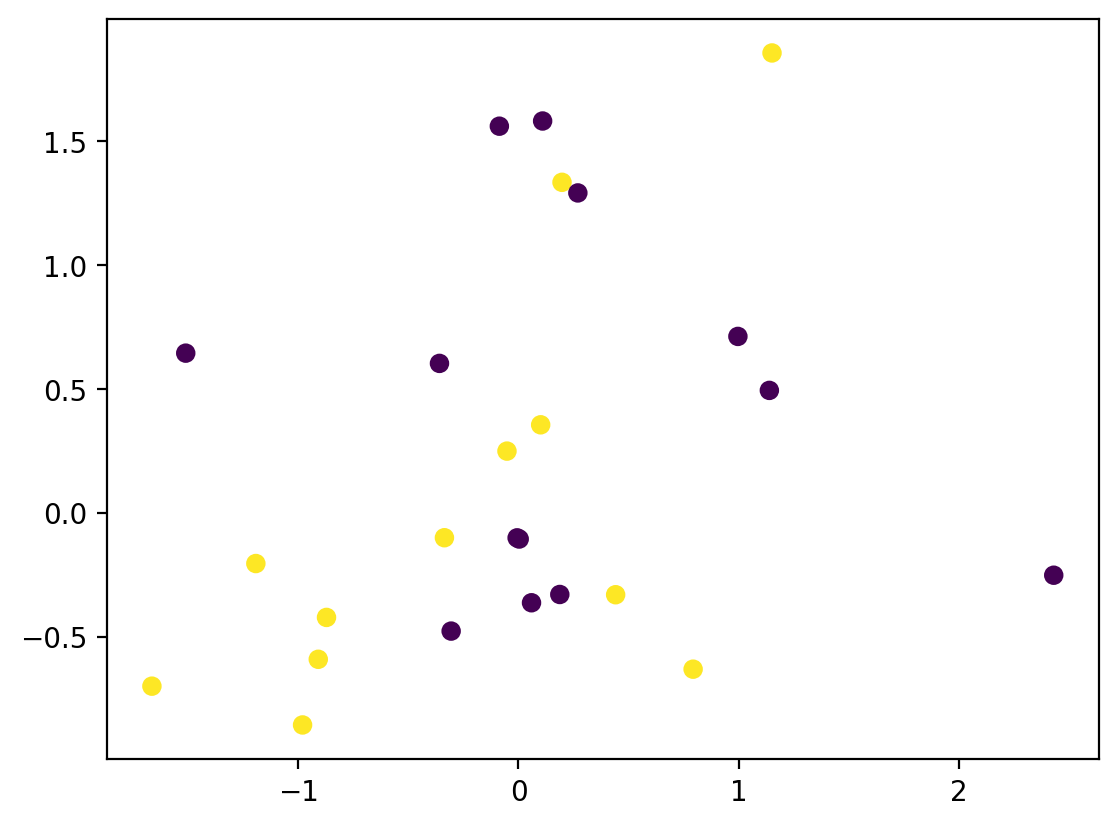

In [5]:
# plot data
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis')
plt.show()

In [6]:
knn = KNN(k=3, method="knn")
knn.fit(X, Y)
for x in X:
	print(x, knn.predict([x]))

[ 0.44122749 -0.33087015] 0
[ 2.43077119 -0.25209213] 0
[0.10960984 1.58248112] 0
[-0.9092324  -0.59163666] 1
[ 0.18760323 -0.32986996] 0
[-1.19276461 -0.20487651] 1
[-0.35882895  0.6034716 ] 1
[-1.66478853 -0.70017904] 1
[1.15139101 1.85733101] 0
[-1.51117956  0.64484751] 0
[-0.98060789 -0.85685315] 1
[-0.87187918 -0.42250793] 1
[0.99643983 0.71242127] 0
[ 0.05914424 -0.36331088] 0
[ 0.00328884 -0.10593044] 0
[ 0.79305332 -0.63157163] 1
[-0.00619491 -0.10106761] 0
[-0.05230815  0.24921766] 1
[0.19766009 1.33484857] 0
[-0.08687561  1.56153229] 0
[-0.30585302 -0.47773142] 0
[0.10073819 0.35543847] 1
[0.26961241 1.29196338] 0
[1.13934298 0.4944404 ] 0
[-0.33633626 -0.10061435] 0


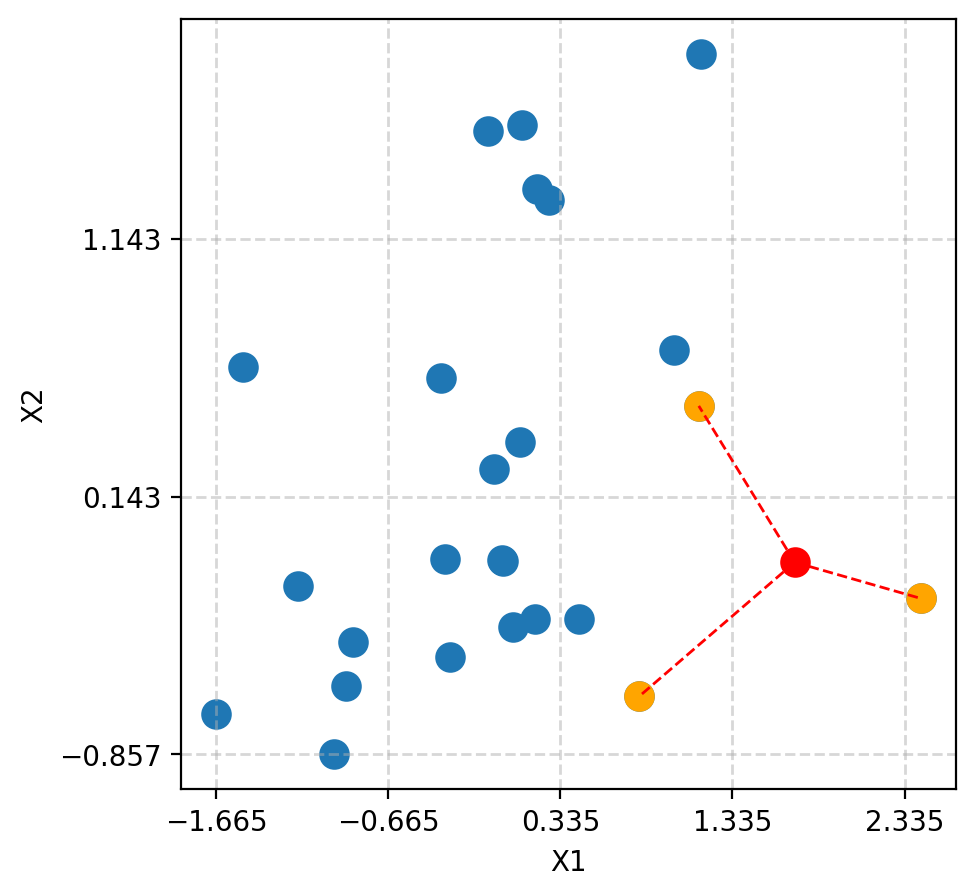

In [7]:
# plot data
knn.visualize(x_test)

In [8]:
kdtree = KNN(k=3, method="kd_tree", max_depth=2)
kdtree.fit(X, Y)
for x in X:
	print(x, kdtree.predict(x))

[ 0.44122749 -0.33087015] 0.0
[ 2.43077119 -0.25209213] 1.0
[0.10960984 1.58248112] 0.0
[-0.9092324  -0.59163666] 1.0
[ 0.18760323 -0.32986996] 0.0
[-1.19276461 -0.20487651] 1.0
[-0.35882895  0.6034716 ] 1.0
[-1.66478853 -0.70017904] 1.0
[1.15139101 1.85733101] 0.0
[-1.51117956  0.64484751] 0.0
[-0.98060789 -0.85685315] 1.0
[-0.87187918 -0.42250793] 1.0
[0.99643983 0.71242127] 0.0
[ 0.05914424 -0.36331088] 0.0
[ 0.00328884 -0.10593044] 0.0
[ 0.79305332 -0.63157163] 1.0
[-0.00619491 -0.10106761] 1.0
[-0.05230815  0.24921766] 1.0
[0.19766009 1.33484857] 0.0
[-0.08687561  1.56153229] 0.0
[-0.30585302 -0.47773142] 1.0
[0.10073819 0.35543847] 0.0
[0.26961241 1.29196338] 0.0
[1.13934298 0.4944404 ] 0.0
[-0.33633626 -0.10061435] 1.0


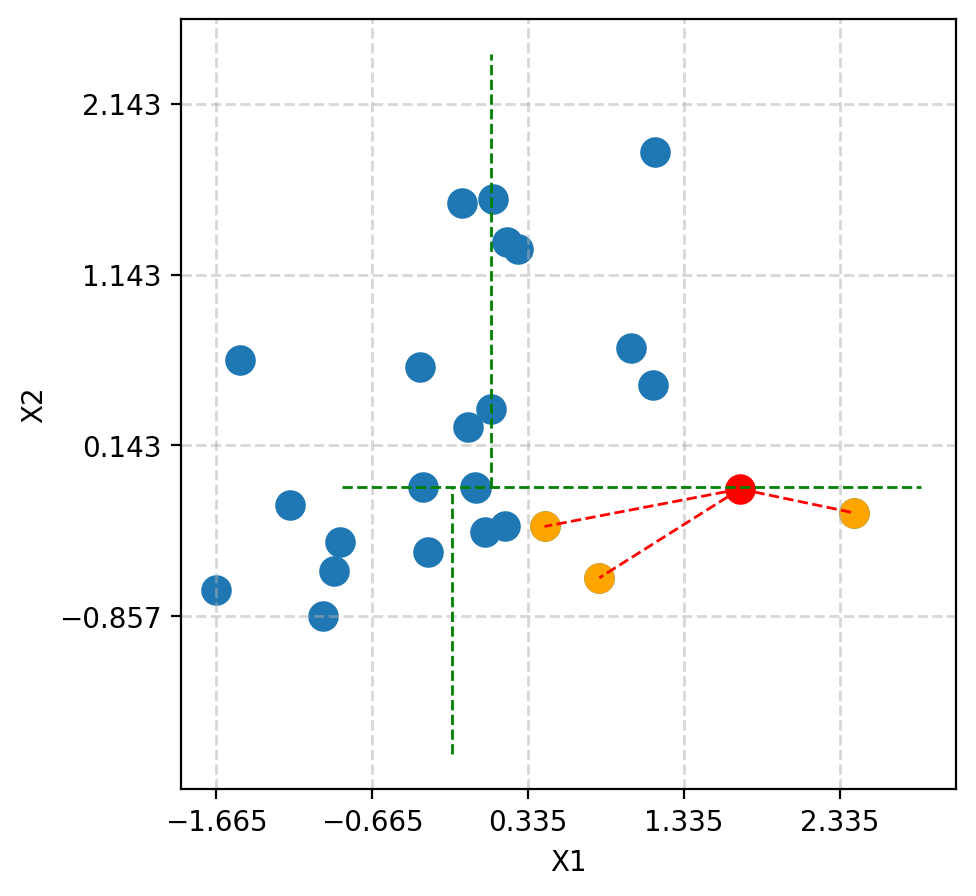

In [9]:
# plot kd tree
kdtree.visualize(x_test)

In [10]:
lsh = KNN(k=3, method="lsh", p=2, l=1)
lsh.fit(X, Y)
for x in X:
	print(x, lsh.predict(x))

[ 0.44122749 -0.33087015] 1
[ 2.43077119 -0.25209213] 0
[0.10960984 1.58248112] 0
[-0.9092324  -0.59163666] 1
[ 0.18760323 -0.32986996] 0
[-1.19276461 -0.20487651] 1
[-0.35882895  0.6034716 ] 1
[-1.66478853 -0.70017904] 1
[1.15139101 1.85733101] 1
[-1.51117956  0.64484751] 0
[-0.98060789 -0.85685315] 1
[-0.87187918 -0.42250793] 1
[0.99643983 0.71242127] 0
[ 0.05914424 -0.36331088] 0
[ 0.00328884 -0.10593044] 0
[ 0.79305332 -0.63157163] 1
[-0.00619491 -0.10106761] 0
[-0.05230815  0.24921766] 1
[0.19766009 1.33484857] 0
[-0.08687561  1.56153229] 0
[-0.30585302 -0.47773142] 0
[0.10073819 0.35543847] 1
[0.26961241 1.29196338] 0
[1.13934298 0.4944404 ] 0
[-0.33633626 -0.10061435] 0


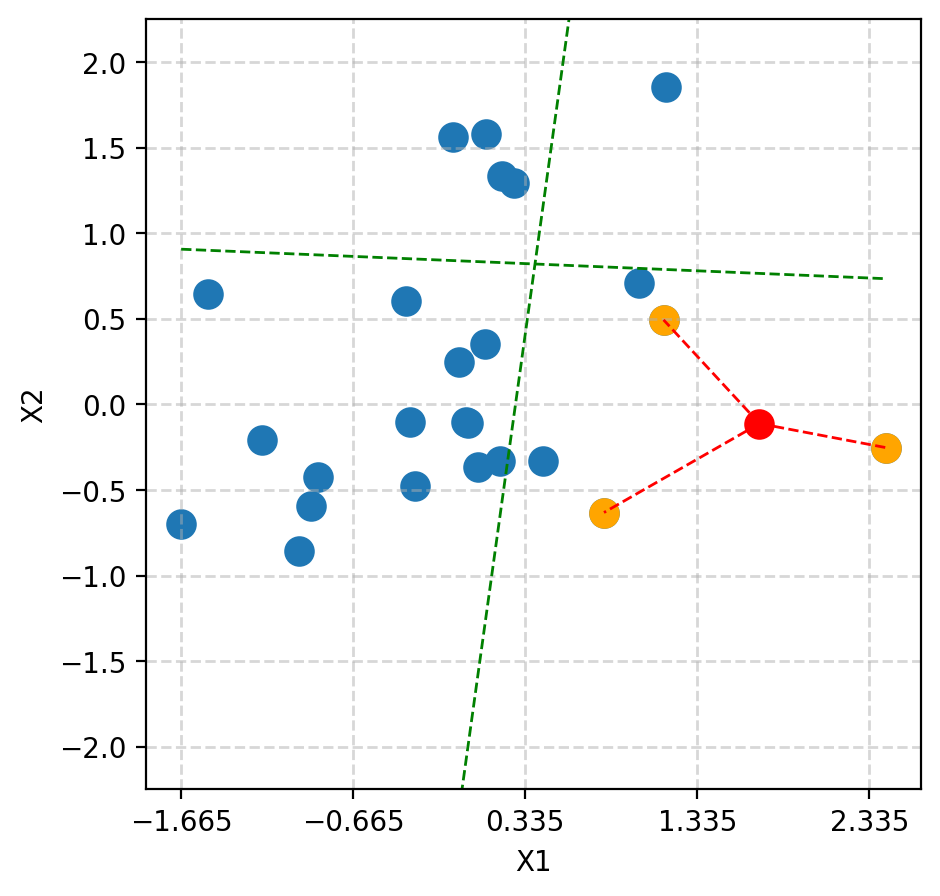

In [11]:
# plot lsh
lsh.visualize(x_test)

# ---------------------------

In [12]:
from time import time
import sys

In [13]:
def test_method(method, n=100, d=2):
    X, Y = get_data(n=n, d=d)
    
    knn = KNN(k=3, method=method)
    
    fitting_time = 0
    start = time()
    knn.fit(X, Y)
    end = time()
    fitting_time = end - start
    
    pred_time = 0
    start = time()
    for x in X:
        knn.predict(x)
    end = time()
    pred_time = end - start
    
    memory = sys.getsizeof(knn)
    
    return fitting_time, pred_time, memory

In [ ]:
for method in ["knn", "kd_tree", "lsh"]:
    fitting_times = []
    pred_times = []
    memories = []
    
    for run in range(100):
        fitting_time, pred_time, memory = test_method(method, n=1000, d=100)
        fitting_times.append(fitting_time)
        pred_times.append(pred_time)
        memories.append(memory)
        
    print(f"Method: {method}")
    print(f"Fitting time: {np.mean(fitting_times):.4f}")
    print(f"Prediction time: {np.mean(pred_times):.4f}")
    print(f"Memory: {np.mean(memories):.4f}")

# W & B

In [14]:
import wandb

In [15]:
ns = [10, 100, 1000, 1000]
ds = [2, 10, 100, 1000]
methods = ["knn", "kd_tree", "lsh"]

In [16]:
for method in methods:
    for n in ns:
        for d in ds:
            fitting_times = []
            pred_times = []
            memories = []
            wandb.init(project="Assignment 4", name=f"{method}_n{n}_d{d}")
            
            for run in range(10):
                fitting_time, pred_time, memory = test_method(method, n=n, d=d)
                fitting_times.append(fitting_time)
                pred_times.append(pred_time)
                memories.append(memory)
            fitting_time = np.mean(fitting_times)
            pred_time = np.mean(pred_times)
            memory = np.mean(memories)
            wandb.log({"method": method, "n": n, "d": d, "fitting_time": fitting_time, "pred_time": pred_time, "memory": memory})
            wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khush24shah. Use `wandb login --relogin` to force relogin


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.0
memory,56.0
method,knn
n,10
pred_time,0.00103


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.0
memory,56.0
method,knn
n,10
pred_time,0.00099


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.0
memory,56.0
method,knn
n,10
pred_time,0.00103


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.0
memory,56.0
method,knn
n,10
pred_time,0.0011


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.0
memory,56.0
method,knn
n,100
pred_time,0.00928


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.0
memory,56.0
method,knn
n,100
pred_time,0.00991


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.0
memory,56.0
method,knn
n,100
pred_time,0.01098


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.0
memory,56.0
method,knn
n,100
pred_time,0.01825


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,0.14288


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,0.14986


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,0.22491


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,1.7961


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,0.13714


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,0.16539


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,0.23381


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.0
memory,56.0
method,knn
n,1000
pred_time,1.71488


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.00013
memory,56.0
method,kd_tree
n,10
pred_time,0.001


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.00014
memory,56.0
method,kd_tree
n,10
pred_time,0.00102


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.00013
memory,56.0
method,kd_tree
n,10
pred_time,0.00101


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.00015
memory,56.0
method,kd_tree
n,10
pred_time,0.001


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.00014
memory,56.0
method,kd_tree
n,100
pred_time,0.00971


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.00014
memory,56.0
method,kd_tree
n,100
pred_time,0.00953


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.00015
memory,56.0
method,kd_tree
n,100
pred_time,0.00981


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.00028
memory,56.0
method,kd_tree
n,100
pred_time,0.01069


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.00028
memory,56.0
method,kd_tree
n,1000
pred_time,0.09975


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.00027
memory,56.0
method,kd_tree
n,1000
pred_time,0.0992


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.0004
memory,56.0
method,kd_tree
n,1000
pred_time,0.1125


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.00226
memory,56.0
method,kd_tree
n,1000
pred_time,0.19773


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.00026
memory,56.0
method,kd_tree
n,1000
pred_time,0.101


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.00028
memory,56.0
method,kd_tree
n,1000
pred_time,0.09977


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.0004
memory,56.0
method,kd_tree
n,1000
pred_time,0.11355


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.00233
memory,56.0
method,kd_tree
n,1000
pred_time,0.20133


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.0001
memory,56.0
method,lsh
n,10
pred_time,0.00102


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,7e-05
memory,56.0
method,lsh
n,10
pred_time,0.00102


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,9e-05
memory,56.0
method,lsh
n,10
pred_time,0.00106


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.0001
memory,56.0
method,lsh
n,10
pred_time,0.00108


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.0001
memory,56.0
method,lsh
n,100
pred_time,0.00969


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.0001
memory,56.0
method,lsh
n,100
pred_time,0.00945


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.00014
memory,56.0
method,lsh
n,100
pred_time,0.00956


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.00027
memory,56.0
method,lsh
n,100
pred_time,0.01208


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.00043
memory,56.0
method,lsh
n,1000
pred_time,0.10442


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.00042
memory,56.0
method,lsh
n,1000
pred_time,0.10699


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.00056
memory,56.0
method,lsh
n,1000
pred_time,0.12491


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.00942
memory,56.0
method,lsh
n,1000
pred_time,0.52023


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,2
fitting_time,0.00041
memory,56.0
method,lsh
n,1000
pred_time,0.10587


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,10
fitting_time,0.00041
memory,56.0
method,lsh
n,1000
pred_time,0.10724


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,100
fitting_time,0.00057
memory,56.0
method,lsh
n,1000
pred_time,0.13256


d,▁
fitting_time,▁
memory,▁
n,▁
pred_time,▁
d,1000
fitting_time,0.01551
memory,56.0
method,lsh
n,1000
pred_time,0.53335
